In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
#plt.style.use('fivethirtyeight')
plt.rc('figure', figsize=(13, 7))

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.api import Holt

from acquire import get_store_data, opsd_germany_daily
import prepare

In [2]:
df = pd.read_csv('BTC-USD.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-11-02,325.941986,365.359985,323.209015,361.188995,361.188995,101918000.0
1,2015-11-03,361.872986,417.899994,357.647003,403.416992,403.416992,206162000.0
2,2015-11-04,403.664001,495.562012,380.548004,411.562988,411.562988,263900000.0
3,2015-11-05,408.076996,447.561005,374.580994,386.354004,386.354004,151824992.0
4,2015-11-06,388.046997,395.835999,354.024994,374.470001,374.470001,122687000.0


In [3]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [4]:
df.Date = pd.to_datetime(df.Date)

df = df.set_index('Date').sort_index()

df=df.resample('W').mean()

df = df[['Close','Volume']]

df.head()

,Close,Volume
Date,,
2015-11-08,385.263284,1.364192e+08
2015-11-15,336.590999,6.919974e+07
2015-11-22,328.581286,4.179563e+07
2015-11-29,344.385568,4.814549e+07
2015-12-06,371.565290,5.955107e+07


In [5]:
df['Close'] = round(df.Close, 2)

In [6]:
df['Volume'] = df.Volume / 1000

In [7]:
df.resample('D').Close.mean().isna().sum()

1567

### Got some decent nulls... Gonna fill them with .ffill

In [8]:
df = pd.DataFrame(df.resample('D').Close.mean().ffill())

In [9]:
df.resample('D').Close.mean().isna().sum()

0

In [10]:
df.head()

,Close
Date,
2015-11-08,385.26
2015-11-09,385.26
2015-11-10,385.26
2015-11-11,385.26
2015-11-12,385.26


In [11]:
train_size = int(len(df) * .5)
validate_size = int(len(df) * .3)
test_size = int(len(df) - train_size - validate_size)

validate_end_index = train_size + validate_size

In [12]:
train = df[: train_size]
validate = df[train_size:validate_end_index]
test = df[validate_end_index:]
train

,Close
Date,
2015-11-08,385.26
2015-11-09,385.26
2015-11-10,385.26
2015-11-11,385.26
2015-11-12,385.26
...,...
2018-05-05,9215.75
2018-05-06,9507.58
2018-05-07,9507.58


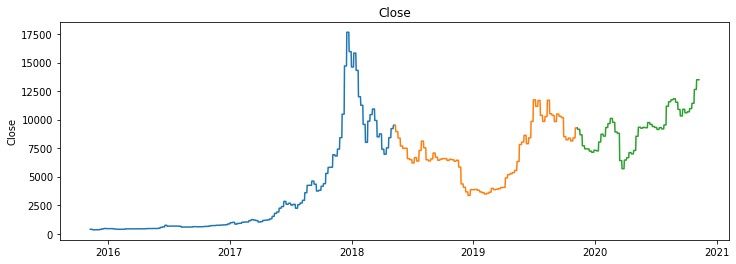

In [13]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [14]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [15]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [16]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

# Last Observed Value

In [17]:
close = train['Close'][-1:][0] #Looking at just the last value

yhat_df = pd.DataFrame({'Close': [close]}, 
                       index = validate.index)

print(yhat_df.shape)
yhat_df.head(2)

(548, 1)


,Close
Date,
2018-05-10,9507.58
2018-05-11,9507.58


Close -- RMSE: 3509


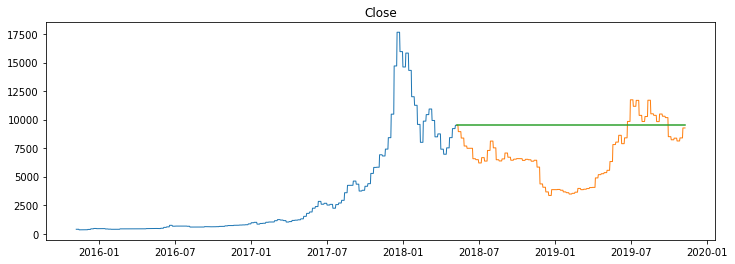

In [18]:
for col in train.columns:
    plot_and_eval(col)

### Evaluate

In [19]:
for col in train.columns:
    eval_df = append_eval_df(model_type='last_observed_value', 
                             target_var = col)
eval_df.head(2)


,model_type,target_var,rmse
0,last_observed_value,Close,3509.0


# Simple Average

In [20]:
close = round(train['Close'].mean(), 2)


def make_predictions():
    yhat_df = pd.DataFrame({'Close': [close],
                           }, index = validate.index)
    return yhat_df

yhat_df = make_predictions()


In [21]:
yhat_df.head(2)

,Close
Date,
2018-05-10,3188.72
2018-05-11,3188.72


Close -- RMSE: 4399


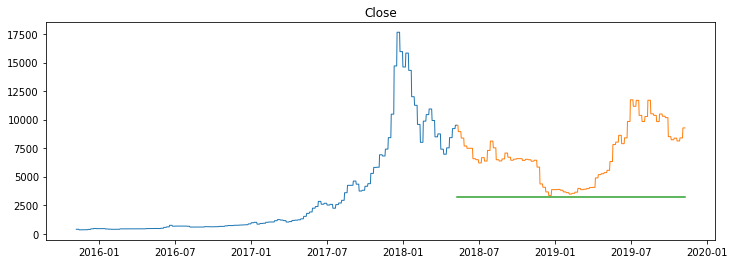

In [22]:
for col in train.columns:
    plot_and_eval(col)

In [23]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)

In [24]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Close,3509.0
1,simple_average,Close,4399.0


# Moving Average

In [25]:
train['Close'].rolling(7).mean()

Date
2015-11-08        NaN
2015-11-09        NaN
2015-11-10        NaN
2015-11-11        NaN
2015-11-12        NaN
               ...   
2018-05-05    9215.75
2018-05-06    9257.44
2018-05-07    9299.13
2018-05-08    9340.82
2018-05-09    9382.51
Freq: D, Name: Close, Length: 914, dtype: float64

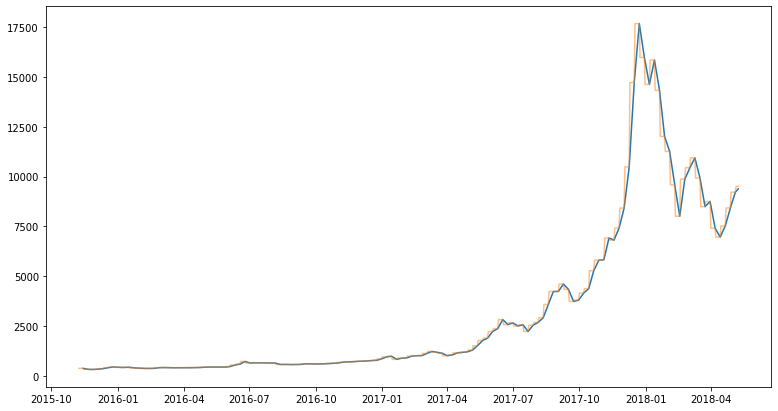

In [26]:
plt.plot(train['Close'].rolling(7).mean())
plt.plot(train['Close'], alpha = .5)

In [27]:
# Keeping it Kosher

print(train['Close'].head(4).mean()) 
print(train['Close'].rolling(4).mean()[3])

385.26
385.26


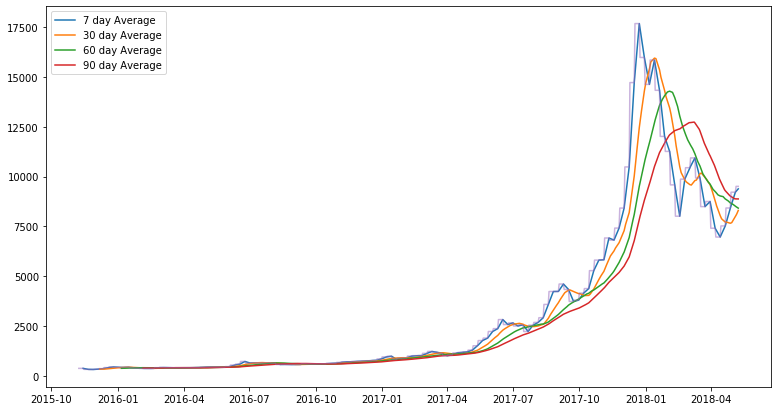

In [28]:
plt.figure(figsize=(13,7))
plt.plot(train['Close'].rolling(7).mean(), label = '7 day Average')
plt.plot(train['Close'].rolling(30).mean(), label = '30 day Average')
plt.plot(train['Close'].rolling(60).mean(), label = '60 day Average')
plt.plot(train['Close'].rolling(90).mean(), label = '90 day Average')
plt.plot(train['Close'], alpha = .5)
plt.legend()

### Make Predictions

In [29]:
period = 7

close = round(train['Close'].rolling(period).mean()[-1], 2)
close

9382.51

In [30]:
yhat_df = make_predictions()
yhat_df.head()

,Close
Date,
2018-05-10,9382.51
2018-05-11,9382.51
2018-05-12,9382.51
2018-05-13,9382.51
2018-05-14,9382.51


Close -- RMSE: 3418


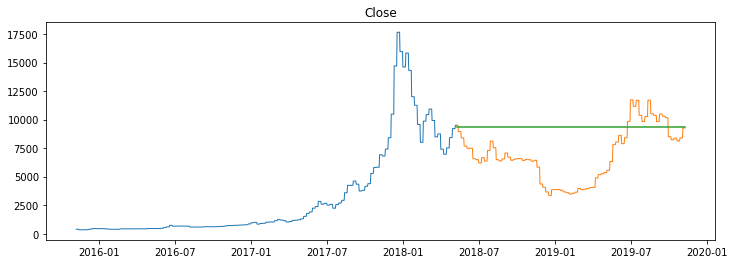

In [31]:
for col in train.columns:
    plot_and_eval(col)


### Evaluate

In [32]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '7D_moving_avg', target_var = col)
    
eval_df

,model_type,target_var,rmse
0,last_observed_value,Close,3509.0
1,simple_average,Close,4399.0
2,7D_moving_avg,Close,3418.0


In [33]:
periods = [7, 30, 60, 90, 120, 150]

for p in periods:
    close = round(train['Close'].rolling(p).mean().iloc[-1], 2)
    
    yhat_df = make_predictions()
    model_type = str(p) + 'D moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'Close'
                            )
    


In [34]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,Close,3509.0
1,simple_average,Close,4399.0
2,7D_moving_avg,Close,3418.0
3,7D moving average,Close,3418.0
4,30D moving average,Close,2737.0
5,60D moving average,Close,2798.0
6,90D moving average,Close,3071.0
7,120D moving average,Close,3715.0
8,150D moving average,Close,4706.0


In [35]:
eval_df.sort_values(by='rmse', ascending = True).head(1)

,model_type,target_var,rmse
4,30D moving average,Close,2737.0


# Holts Linear Trend

### Seasonal Decomposition

Close 



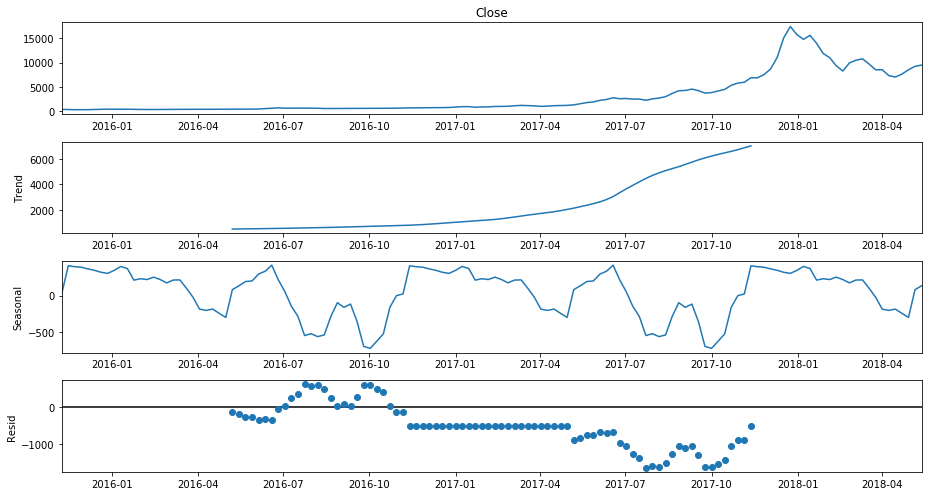

In [36]:
for col in train.columns:
    print(col, '\n')
    sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()
    plt.show()

### Predictions

In [37]:
for col in train.columns:
    model = Holt(train.resample('D')[col].mean(), exponential = False, damped=True)
    model = model.fit(smoothing_level = .4, 
                      smoothing_slope = .5, 
                      optimized = True)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

In [38]:
yhat_df.head()

,Close
Date,
2018-05-10,9466.8
2018-05-11,9466.8
2018-05-12,9466.8
2018-05-13,9466.8
2018-05-14,9466.8


Close -- RMSE: 3479


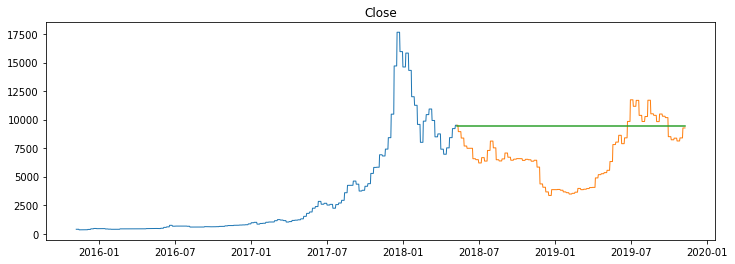

In [39]:
for col in train.columns:
    plot_and_eval(target_var = col)


### Evaluate

In [40]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [41]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
4,30D moving average,Close,2737.0
5,60D moving average,Close,2798.0
6,90D moving average,Close,3071.0
2,7D_moving_avg,Close,3418.0
3,7D moving average,Close,3418.0
9,holts_optimized,Close,3479.0
0,last_observed_value,Close,3509.0
7,120D moving average,Close,3715.0
1,simple_average,Close,4399.0
8,150D moving average,Close,4706.0


# Predict based on previous cycle

In [42]:
train = df[:'2018']
validate = df['2019']
test = df['2020']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()


(1150, 1)
(365, 1)
(313, 1)


,Close
Date,
2015-11-08,385.26
2015-11-09,385.26
2015-11-10,385.26
2015-11-11,385.26
2015-11-12,385.26


In [43]:
yhat_df = train['2018'] + train.diff(365).mean()

In [44]:
pd.concat([yhat_df.head(1), validate.head(1)])

,Close
Date,
2018-01-01,17988.437911
2019-01-01,3859.500000


In [45]:
yhat_df.head()

,Close
Date,
2018-01-01,17988.437911
2018-01-02,17988.437911
2018-01-03,17988.437911
2018-01-04,17988.437911
2018-01-05,17988.437911


Close -- RMSE: 6005


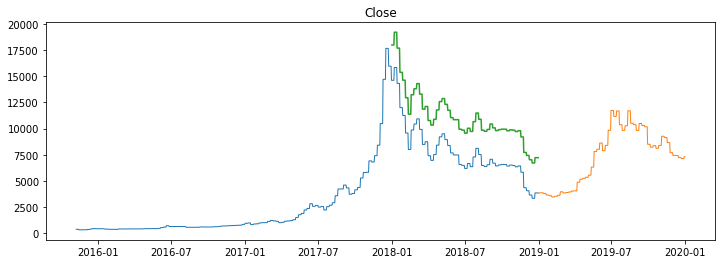

In [46]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_year", 
                            target_var = col)

# Which Model did Best?

In [47]:
close_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]


# find which model that is
eval_df[(eval_df.rmse == close_min_rmse)]

,model_type,target_var,rmse
4,30D moving average,Close,2737.0


# Time to test it

In [48]:
period = 30

close = round(train['Close'].rolling(period).mean()[-1], 2)
close

3745.18

In [49]:
yhat_df = make_predictions()
yhat_df.head()

,Close
Date,
2019-01-01,3745.18
2019-01-02,3745.18
2019-01-03,3745.18
2019-01-04,3745.18
2019-01-05,3745.18


In [50]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

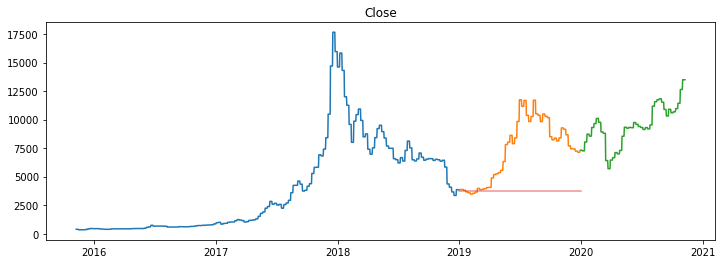

In [51]:
for col in train.columns:
    final_plot(col)


# Adding Bollinger Bands

In [52]:
df = pd.read_csv('BTC-USD.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-11-02,325.941986,365.359985,323.209015,361.188995,361.188995,101918000.0
1,2015-11-03,361.872986,417.899994,357.647003,403.416992,403.416992,206162000.0
2,2015-11-04,403.664001,495.562012,380.548004,411.562988,411.562988,263900000.0
3,2015-11-05,408.076996,447.561005,374.580994,386.354004,386.354004,151824992.0
4,2015-11-06,388.046997,395.835999,354.024994,374.470001,374.470001,122687000.0


In [53]:
df.Date = pd.to_datetime(df.Date)

df = df.set_index('Date').sort_index()

df=df.resample('D').mean()

In [54]:
def bb(df, dev=2.5, lb=50, col="Close", lines=100):
    df['MA'] = df[col].rolling(lb).mean()
    df['STD'] = df[col].rolling(lb).std()
    df['OVB'] = df['MA'] + df['STD'] * dev
    df['OVS'] = df['MA'] - df['STD'] * dev
    plot_candles(df, lines=lines)
    get_stats(df, dev=dev)

In [55]:
def plot_candles(df, lines=100):
    df['Bar'] = df['High'] - df['Low']
    df['Body'] = abs(df['Close'] - df['Open'])
    df['Up'] = df['Close'] > df['Open']
    df['Color'] = np.where(df['Up'], "g", "r")
    if lines > 0:
        db = df[-lines:].reset_index(drop=True).reset_index()
    else:
        db = df.reset_index(drop=True).reset_index()
    plt.figure(figsize=(15, 10))
    plt.bar(db['index'], bottom=db['Low'], height=db['Bar'], color="#000000", width=0.2)
    plt.bar(db['index'], bottom=np.where(db['Up'], db['Open'], db['Close']), height=db['Body'], color=db['Color'], width=0.9)
    plt.plot(db['OVB'], color="b")
    plt.plot(db['OVS'], color="b")
    plt.show()

In [56]:
def get_stats(df, high_col="Close", low_col="Close", high_dev="OVB", low_dev="OVS", dev=2.5):
    total = len(df)
    inside = len(df[(df[high_col]<=df[high_dev]) & (df[low_col]>=df[low_dev])])
    upside = len(df[df[high_col]>=df[high_dev]])
    downside = len(df[df[low_col]<=df[low_dev]])
    i = np.round(inside / total * 100, 2)
    u = np.round(upside / total * 100, 2)
    d = np.round(downside / total * 100, 2)
    # Print the stats
    print("Total bars:", total)
    print("Deviation", dev)
    print("Inside: ", i, "%", sep="")
    print("Up side: ", u, "%", sep="")
    print("Down side: ", d, "%", sep="")

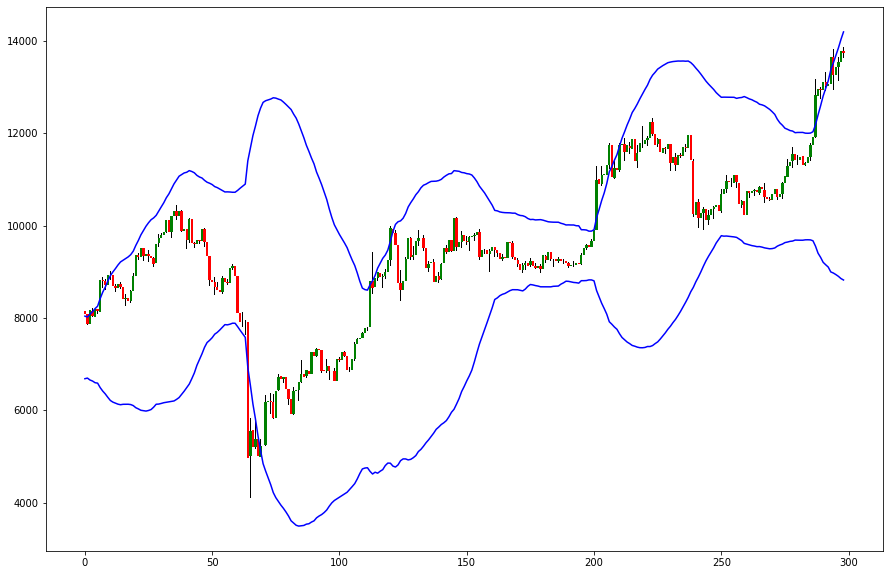

Total bars: 1828
Deviation 2.5
Inside: 89.22%
Up side: 6.56%
Down side: 1.48%


In [57]:
dev = 2.5 
lb = 50 
lines = 300 
bb(df, dev=dev, lb=lb, lines=lines)

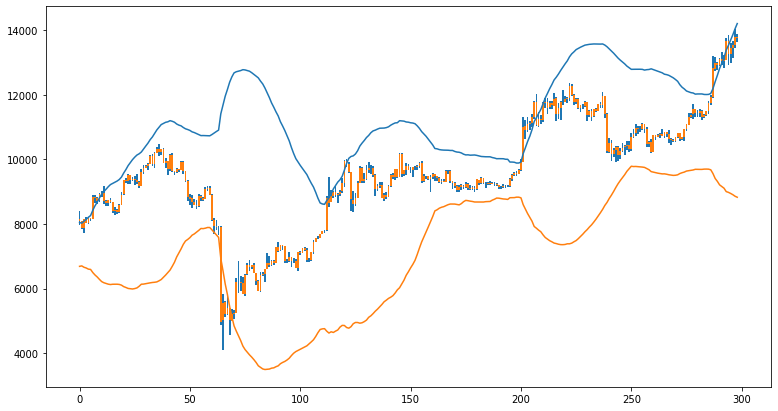

In [67]:
df['MA'] = df['Close'].rolling(50).mean()
df['STD'] = df['Close'].rolling(50).std()
df['OVB'] =df['MA'] + df['STD'] * dev
df['OVS'] =df['MA'] - df['STD'] * dev

df['Bar'] = df['High'] - df['Low']
df['Body'] = abs(df['Close'] - df['Open'])
df['Up'] = df['Close'] > df['Open']
df['Color'] = np.where(df['Up'], "g", "r")

if lines > 0:
        db = df[-lines:].reset_index(drop=True).reset_index()
else:
        db = df.reset_index(drop=True).reset_index()

high_dev="OVB"
low_dev="OVS"
dev=2.5

total = len(df)
inside = len(df[(df['Close']<=df[high_dev]) & (df['Close']>=df[low_dev])])
upside = len(df[df['Close']>=df[high_dev]])
downside = len(df[df['Close']<=df[low_dev]])

plt.figure(figsize=(13, 7))
plt.bar(db['index'], bottom=db['Low'], height=db['Bar'])
plt.bar(db['index'], bottom=np.where(db['Up'], db['Open'], db['Close']), height=db['Body'])
plt.plot(db['OVB'])
plt.plot(db['OVS'])